Objective of this problem is to predict the closing price of Tesla stocks. 
We have Tesla price from 2010 July to 2017 March in the data set.

In this notebook I'm trying to predict the closing price of Tesla in the year of 2017 with the help of LSTM model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Finance/Tesla.csv - Tesla.csv.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988
1691,3/17/2017,264.000000,265.329987,261.200012,261.500000,6475900,261.500000


The data set consisits of stock price of Tesla company from 2010 JULY to 2017 March include opening price and closing price each day

We will use the 2017 values for testing and rest of the data for the trainig purpose here

in the data set I'm using only the date and closing price as variables in model trainig we can ignore the other variables

In [5]:
data.shape

(1692, 7)

In [6]:
cols = ['Date','Close']
data= data[cols]

In [7]:
data.head()

,Date,Close
0,6/29/2010,23.889999
1,6/30/2010,23.830000
2,7/1/2010,21.959999
3,7/2/2010,19.200001
4,7/6/2010,16.110001


In [8]:
data.isnull().sum()

Date     0
Close    0
dtype: int64

the data doesnt have any null values

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1692 non-null   object 
 1   Close   1692 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.6+ KB


The date column is in object and need to convert into the date time format

In [10]:
data['Date']= pd.to_datetime(data['Date'])

now set the data sorted by the date column as index

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1692 non-null   datetime64[ns]
 1   Close   1692 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.6 KB


In [12]:
data= data.set_index('Date')

In [13]:
data.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


**Exploratory Data Analysis**

first will will split the data from 2017 we used for predictions 

In [14]:
train_df=data.loc[:'12/30/2016']
test_df = data.loc['1/3/2017':]

In [15]:
train_df.tail()

,Close
Date,
2016-12-23,213.339996
2016-12-27,219.529999
2016-12-28,219.740005
2016-12-29,214.679993
2016-12-30,213.690002


In [16]:
test_df.head()

,Close
Date,
2017-01-03,216.990005
2017-01-04,226.990005
2017-01-05,226.750000
2017-01-06,229.009995
2017-01-09,231.279999


We will plot the closing price w.r.t to time in train data

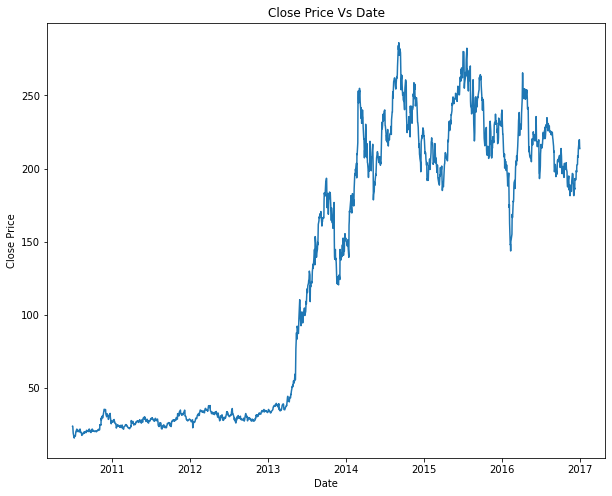

In [17]:
plt.figure(figsize=[10,8])                                   # Setting the figure size
plt.plot(train_df['Close'])                                  # Plotting the close price
plt.xlabel("Date")                                           # Setting the label in x-axis
plt.ylabel("Close Price")                                    # Setting the label in y-axis
plt.title("Close Price Vs Date")                             # Title
plt.show()

We can see that the closing price increased after 2013 for Tesla very high 
and we can see that for prediciton need few data points in the previous value otherwise the model will fail to predicting the next closing price

Also we need to do price normalisation here,since the closing price is not following a normal distribution so will use minmax scalar here for normalisaton

In [18]:
len(train_df)

1640

We have 1640 days data in the training set 

we will remove the last 30 days from the train and use those in validation set

In [19]:
train_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [20]:
prediction_days = 30
ts_train= train_df[:1610]       # Remove 30 days from the end for Training data
ts_valid= train_df[1610:] 

In [21]:
ts_train.shape

(1610, 1)

In [22]:
ts_train.tail()

,Close
Date,
2016-11-10,185.350006
2016-11-11,188.559998
2016-11-14,181.449997
2016-11-15,183.770004
2016-11-16,183.929993


In [23]:
ts_valid.head()

,Close
Date,
2016-11-17,188.660004
2016-11-18,185.020004
2016-11-21,184.520004
2016-11-22,191.169998
2016-11-23,193.139999


In [24]:
from keras.models import Sequential                   # Sequential model
from keras.layers import Dense                        # For fully connected layers
from keras.layers import LSTM                         # For LSTM layers
from sklearn.preprocessing import MinMaxScaler        # Scaling the data
min_max_scaler = MinMaxScaler()

In [25]:
training_set=ts_train.values
training_set = min_max_scaler.fit_transform(training_set)

Defining our X and y
X is our inputs which is the training data.
y is the output, which is training data shifted by 1day

For a given day, we want to predict the stock value for the next day.

In [83]:
x_train=training_set[0:len(training_set)-1]
y_train=training_set[1:len(training_set)]

In [27]:
x_train[:5]

array([[0.02993635],
       [0.02971433],
       [0.02279455],
       [0.01258141],
       [0.00114713]])

In [28]:
y_train[:5]

array([[0.02971433],
       [0.02279455],
       [0.01258141],
       [0.00114713],
       [0.        ]])

In [29]:
len(x_train),len(y_train)

(1609, 1609)

**Model Buiding part**

before giving input to the neural network we need to broadcast out x_train to a 3D vector as required by the neural network

In [30]:
x_train = np.reshape(x_train, (len(x_train), 1, 1))  

In [31]:
x_train[:10]

array([[[0.02993635]],

       [[0.02971433]],

       [[0.02279455]],

       [[0.01258141]],

       [[0.00114713]],

       [[0.        ]],

       [[0.00614268]],

       [[0.00592066]],

       [[0.00462551]],

       [[0.00865897]]])

defining the paramters in the neural network here

In [32]:
num_units = 64
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 10
num_epochs = 50

In [33]:
#trainig from the data 2010-08-04 to 30 days

regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model
regressor.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs)

Epoch 1/50
161/161 [==============================] - 3s 4ms/step - loss: 0.1206
Epoch 2/50
161/161 [==============================] - 1s 4ms/step - loss: 0.0630
Epoch 3/50
161/161 [==============================] - 1s 4ms/step - loss: 0.0284
Epoch 4/50
161/161 [==============================] - 1s 4ms/step - loss: 0.0077
Epoch 5/50
161/161 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 6/50
161/161 [==============================] - 1s 4ms/step - loss: 3.4390e-04
Epoch 7/50
161/161 [==============================] - 1s 4ms/step - loss: 2.6556e-04
Epoch 8/50
161/161 [==============================] - 1s 4ms/step - loss: 2.5008e-04
Epoch 9/50
161/161 [==============================] - 1s 4ms/step - loss: 2.6594e-04
Epoch 10/50
161/161 [==============================] - 1s 4ms/step - loss: 2.8087e-04
Epoch 11/50
161/161 [==============================] - 1s 4ms/step - loss: 2.5763e-04
Epoch 12/50
161/161 [==============================] - 1s 4ms/step - loss: 2.5348e-

**Predcition on the validation data data**

In [34]:
test_set = ts_valid.values

inputs = np.reshape(test_set, (len(test_set), 1))                        # Reshape before passing in the input
inputs = min_max_scaler.transform(inputs)                                # Scaling the data
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = regressor.predict(inputs)                              # Make predictions on the test data
predicted_price = min_max_scaler.inverse_transform(predicted_price)      # Inverse transform the predicted price

In [35]:
predicted_price  

array([[189.54276],
       [185.93835],
       [185.44304],
       [192.0266 ],
       [193.97508],
       [197.44472],
       [196.92097],
       [190.44344],
       [190.27516],
       [182.82687],
       [182.42046],
       [187.70126],
       [186.76048],
       [193.98499],
       [193.13448],
       [193.02565],
       [193.2729 ],
       [198.92665],
       [199.45999],
       [198.36357],
       [203.21147],
       [203.44829],
       [209.42369],
       [208.34955],
       [209.08864],
       [213.9045 ],
       [219.99225],
       [220.19862],
       [215.22318],
       [214.24898]], dtype=float32)

In [36]:
error=predicted_price-test_set   # check the errors in each prediction

In [37]:
error

array([[0.88275113],
       [0.91835049],
       [0.92303494],
       [0.85659807],
       [0.8350834 ],
       [0.79472341],
       [0.80097973],
       [0.87342867],
       [0.87516774],
       [0.94686878],
       [0.95045493],
       [0.90126043],
       [0.91047679],
       [0.83499135],
       [0.84448271],
       [0.84565702],
       [0.84291044],
       [0.776657  ],
       [0.76998946],
       [0.78356917],
       [0.72146656],
       [0.71829196],
       [0.6336978 ],
       [0.64955134],
       [0.63864131],
       [0.56449924],
       [0.46224954],
       [0.45861866],
       [0.54318205],
       [0.55897566]])

Visualisation of the predcitions vs actual

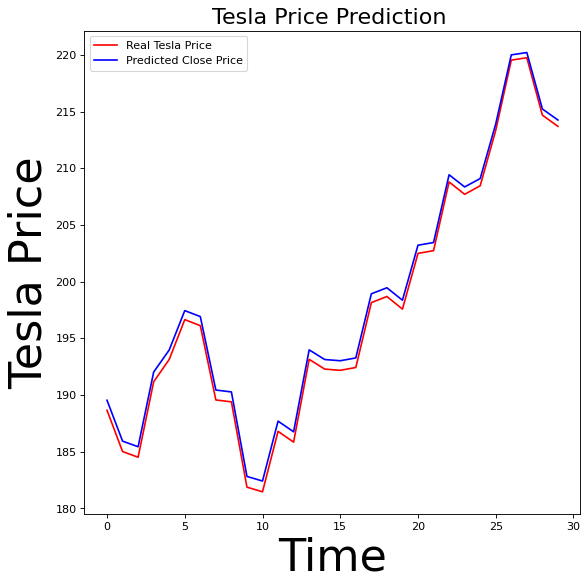

In [38]:
plt.figure(figsize=(8, 8), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set[:, 0], color='red', label='Real Tesla Price')                      # Actual Price
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted Close Price')      # Predicted Price

plt.title('Tesla Price Prediction ', fontsize = 20)
plt.xlabel('Time', fontsize=40)
plt.ylabel('Tesla Price', fontsize = 40)
plt.legend(loc = 'best')
plt.show()

The model performed satisfactory , now we will test the model with the 2017 data set which we kept for testing 

**Prediction with the Test data**

In [69]:
test_df.head()

,Close
Date,
2017-01-03,216.990005
2017-01-04,226.990005
2017-01-05,226.750000
2017-01-06,229.009995
2017-01-09,231.279999


We need to do feature enginnering before feeding into the network

In [70]:
test_data1=np.array(test_df)

In [71]:
test_data1[:10]

array([[216.990005],
       [226.990005],
       [226.75    ],
       [229.009995],
       [231.279999],
       [229.869995],
       [229.729996],
       [229.589996],
       [237.75    ],
       [235.580002]])

In [72]:
test_input=min_max_scaler.transform(test_data1) #normalising the values of data

In [73]:
test_input=np.reshape(test_input, (len(test_input), 1, 1)) #the 3d vector form required by the neural network

In [74]:
test_prediction=regressor.predict(test_input)    # making prediction

In [75]:
test_prediction=min_max_scaler.inverse_transform(test_prediction) # converting back to the normal prize 

In [76]:
test_prediction[:10]

array([[217.49535],
       [227.31624],
       [227.08084],
       [229.29698],
       [231.52155],
       [230.13992],
       [230.0027 ],
       [229.86548],
       [237.8545 ],
       [235.73172]], dtype=float32)

In [77]:
test_df['Close'][:10]

Date
2017-01-03    216.990005
2017-01-04    226.990005
2017-01-05    226.750000
2017-01-06    229.009995
2017-01-09    231.279999
2017-01-10    229.869995
2017-01-11    229.729996
2017-01-12    229.589996
2017-01-13    237.750000
2017-01-17    235.580002
Name: Close, dtype: float64

In [80]:
error=test_prediction-test_data1 # errors in prediction

In [81]:
error

array([[ 0.50534107],
       [ 0.3262334 ],
       [ 0.33084106],
       [ 0.28698681],
       [ 0.24154641],
       [ 0.2699281 ],
       [ 0.27270481],
       [ 0.27548252],
       [ 0.10450745],
       [ 0.15171797],
       [ 0.09100303],
       [-0.03305103],
       [-0.05615262],
       [-0.15917952],
       [-0.30711404],
       [-0.30335976],
       [-0.2514043 ],
       [-0.26298528],
       [-0.20265209],
       [-0.23626741],
       [-0.16725109],
       [-0.2263946 ],
       [-0.22070329],
       [-0.39337157],
       [-0.38534547],
       [-0.51583905],
       [-0.73046854],
       [-0.73138429],
       [-1.1071166 ],
       [-1.12036134],
       [-1.07791161],
       [-0.72265604],
       [-0.82650758],
       [-0.99685704],
       [-0.86801171],
       [-0.34445141],
       [-0.37210083],
       [-0.09246853],
       [-0.18626354],
       [-0.18704196],
       [-0.19877652],
       [-0.22688261],
       [-0.21757536],
       [-0.15089383],
       [-0.10813892],
       [-0

Will plot the error to check the predictions

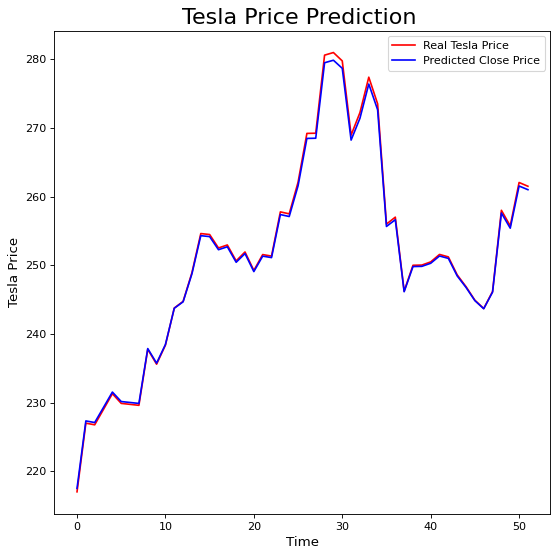

In [82]:
plt.figure(figsize=(8, 8), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(test_data1[:, 0], color='red', label='Real Tesla Price')                      # Actual Price
plt.plot(test_prediction[:, 0], color = 'blue', label = 'Predicted Close Price')      # Predicted Price

plt.title('Tesla Price Prediction ', fontsize = 20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Tesla Price', fontsize = 12)
plt.legend(loc = 'best')
plt.show()



Model is able to predict the closing price very well by this LSTM model